In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from time import time
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})

# mne import
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap, Xdawn)
from mne.time_frequency import AverageTFR
from mne.channels import make_standard_montage
from mne.decoding import LinearModel, Vectorizer, get_coef, Scaler, CSP, SPoC, UnsupervisedSpatialFilter
from mne.time_frequency import psd_welch
mne.set_log_level('WARNING')

import sklearn
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Preprocessing, parsing and formating

In [2]:
subject = [1] # 1, 4
run_execution = [5, 9, 13]
run_imagery = [6, 10, 14]

raw_files = []

for person_number in subject:
    for i, j in zip(run_execution, run_imagery):
        raw_files_execution = [read_raw_edf(f, preload=True, stim_channel='auto') for f in eegbci.load_data(person_number, i)]
        raw_files_imagery = [read_raw_edf(f, preload=True, stim_channel='auto') for f in eegbci.load_data(person_number, j)]
        
        raw_execution = concatenate_raws(raw_files_execution)
        raw_imagery = concatenate_raws(raw_files_imagery)

        events, _ = mne.events_from_annotations(raw_execution, event_id=dict(T0=1,T1=2,T2=3))
        mapping = {1:'rest', 2: 'do/feet', 3: 'do/hands'}
        annot_from_events = mne.annotations_from_events(
            events=events, event_desc=mapping, sfreq=raw_execution.info['sfreq'],
            orig_time=raw_execution.info['meas_date'])
        raw_execution.set_annotations(annot_from_events)
        
        events, _ = mne.events_from_annotations(raw_imagery, event_id=dict(T0=1,T1=2,T2=3))
        mapping = {1:'rest', 2: 'imagine/feet', 3: 'imagine/hands'}
        annot_from_events = mne.annotations_from_events(
            events=events, event_desc=mapping, sfreq=raw_imagery.info['sfreq'],
            orig_time=raw_imagery.info['meas_date'])
        raw_imagery.set_annotations(annot_from_events)
        
        
        raw_files.append(raw_execution)
        raw_files.append(raw_imagery)

In [3]:
raw_files

[<RawEDF | S001R05.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>,
 <RawEDF | S001R06.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>,
 <RawEDF | S001R09.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>,
 <RawEDF | S001R10.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>,
 <RawEDF | S001R13.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>,
 <RawEDF | S001R14.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>]

In [4]:
raw = concatenate_raws(raw_files)
events, event_dict = mne.events_from_annotations(raw)
print(raw.info)
print(event_dict)

<Info | 7 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>
{'do/feet': 1, 'do/hands': 2, 'imagine/feet': 3, 'imagine/hands': 4, 'rest': 5}


In [5]:
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
print (picks)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


### Standardize ch_names

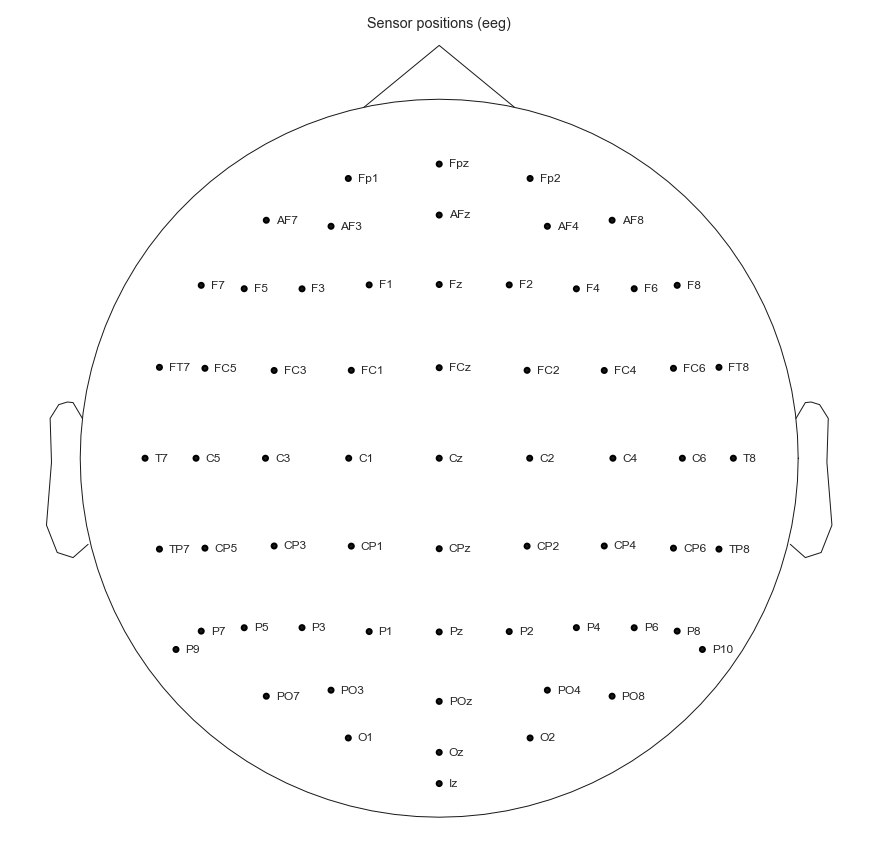

In [6]:
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
biosemi_montage.plot()
plt.show()

In [7]:
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

<RawEDF | S001R05.edf, 64 x 120000 (750.0 s), ~58.8 MB, data loaded>

### Some Graphs

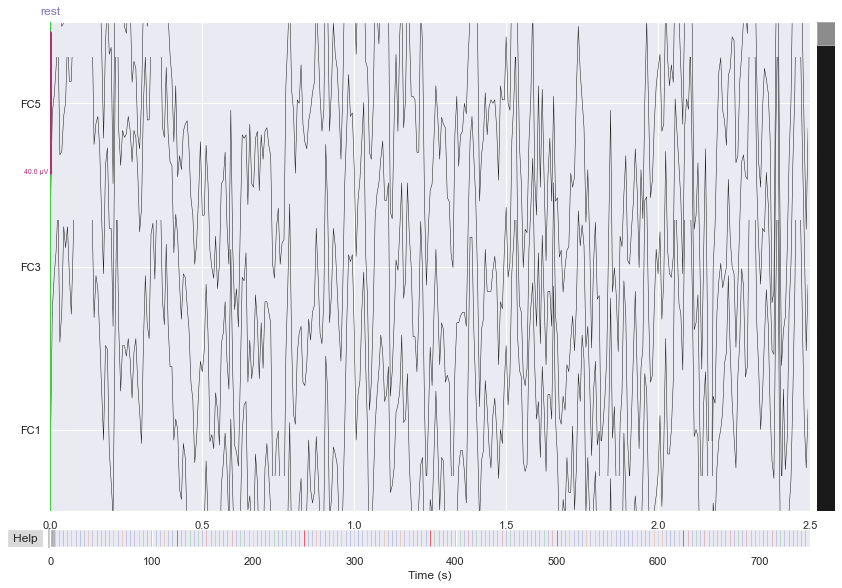

In [8]:
raw.plot(n_channels=3, duration = 2.5)
plt.show()

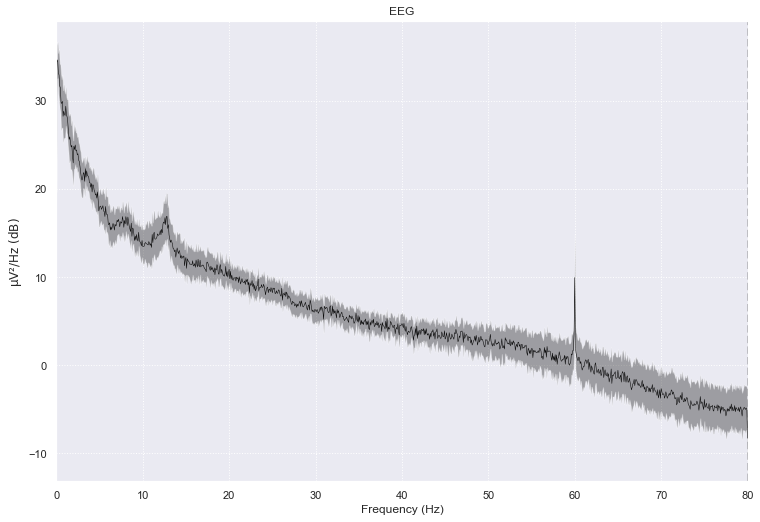

In [9]:
raw.plot_psd(average=True)
plt.show()

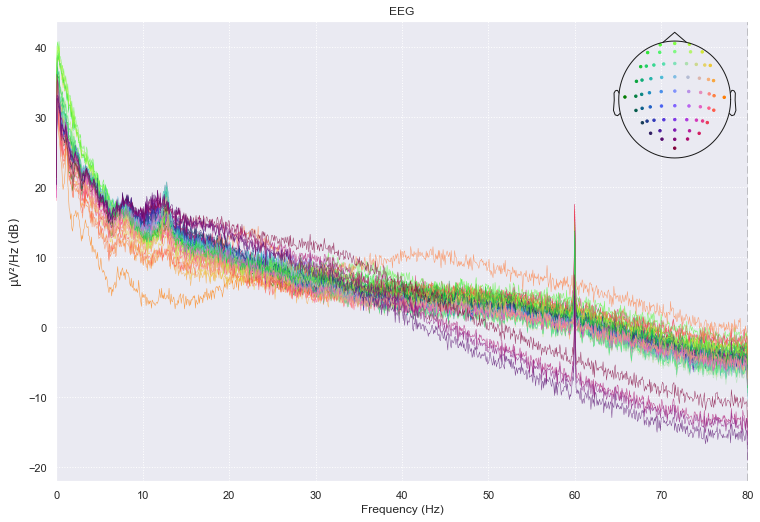

In [10]:
raw.plot_psd(average=False)
plt.show()

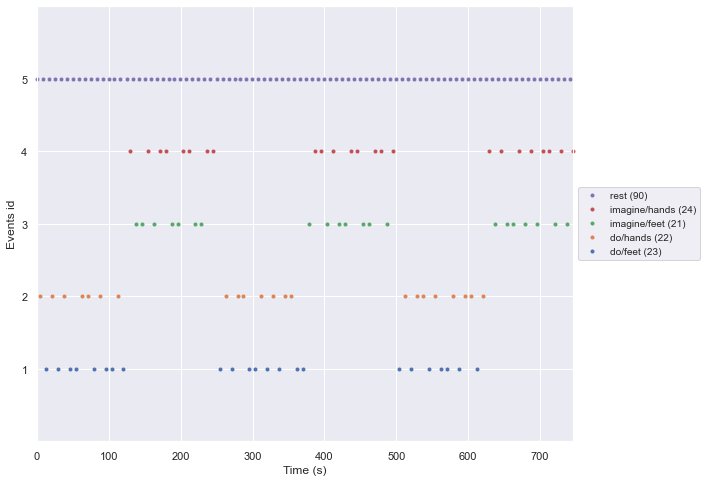

In [11]:
fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, event_id=event_dict)
fig.subplots_adjust(right=0.7)  # make room for legend

# Example of Filter and ICA

In [12]:
raw.filter(5., 40., fir_design='firwin', skip_by_annotation='edge')

<RawEDF | S001R05.edf, 64 x 120000 (750.0 s), ~58.8 MB, data loaded>

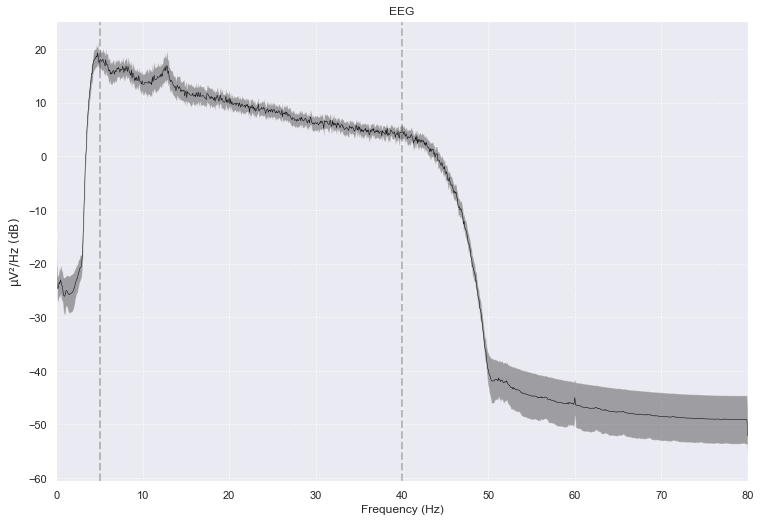

In [13]:
raw.plot_psd(average=True)
plt.show()

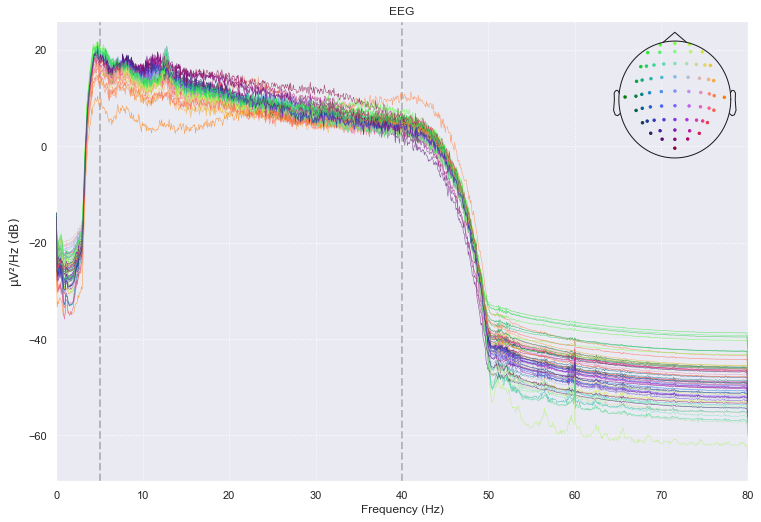

In [14]:
raw.plot_psd(average=False)
plt.show()

In [15]:
def run_ica(raw, method, fit_params=None):
    raw_corrected = raw.copy()
    n_components=20
    
    ica = ICA(n_components=n_components, method=method, fit_params=fit_params, random_state=97)
    t0 = time()
    ica.fit(raw_corrected, picks=picks)
    fit_time = time() - t0
    title = ('ICA decomposition using %s (took %.1fs)' % (method, fit_time))
    ica.plot_components(title=title)
    plt.show()
    
    eog_indices, scores = ica.find_bads_eog(raw, ch_name='Fpz',threshold=1.5)
    ica.plot_scores(scores, exclude=eog_indices)  # look at r scores of components
    ica.exclude.extend(eog_indices) 
    raw_corrected = ica.apply(raw_corrected, n_pca_components = n_components, exclude = ica.exclude)
    print(ica.exclude, ica.labels_)
    return raw_corrected

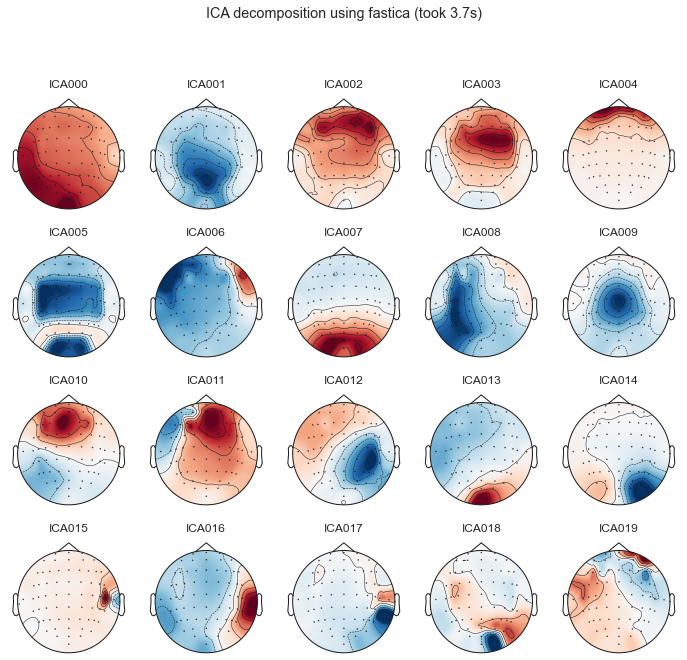

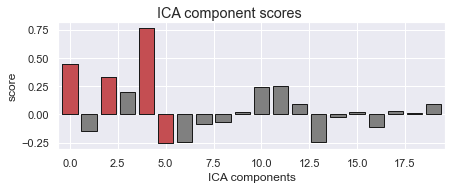

[4, 0, 2, 5] {'eog/0/Fpz': [0, 2, 4, 5], 'eog': [4, 0, 2, 5]}


In [16]:
raw_fastica = run_ica(raw, 'fastica')

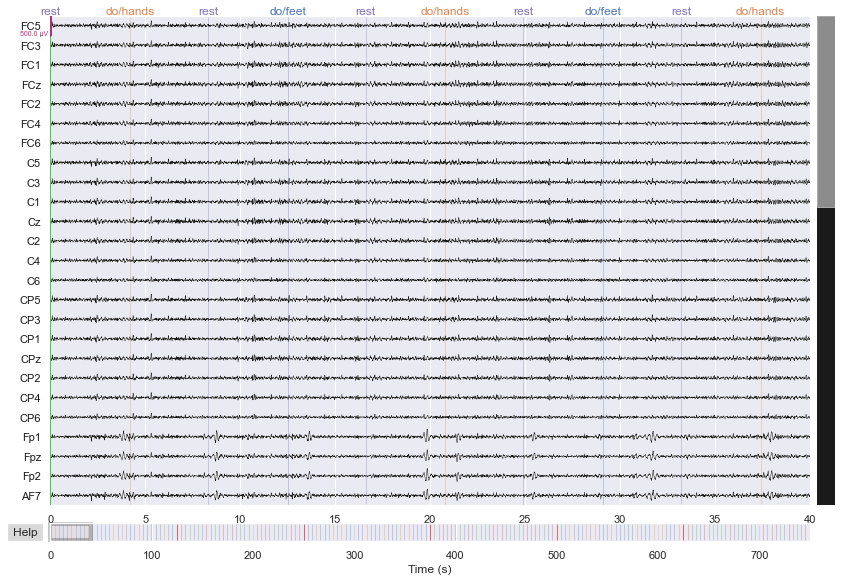

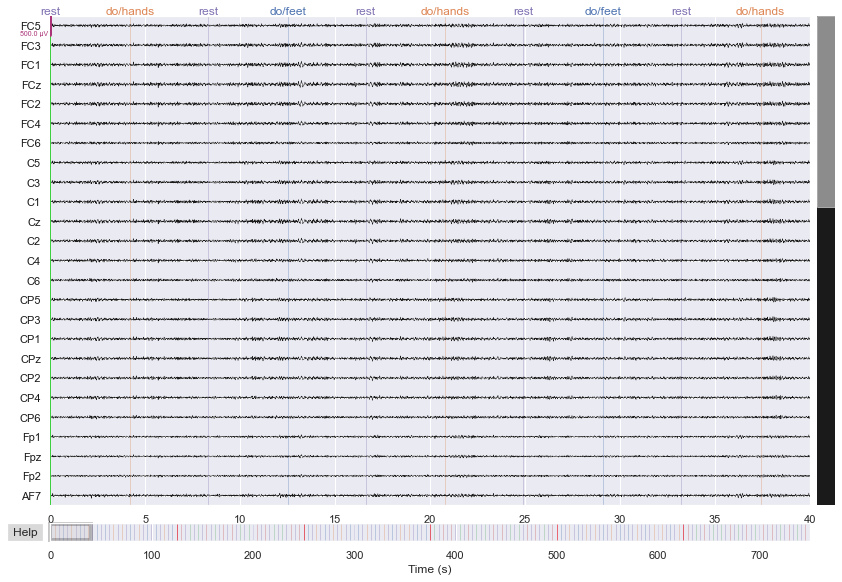

In [17]:
raw.plot(n_channels=25, start=0, duration=40,scalings=dict(eeg=250e-6))
raw_fastica.plot(n_channels=25, start=0, duration=40,scalings=dict(eeg=250e-6))
plt.show()

# Converting to EPOCHS

In [18]:
event_id = {'do/feet': 1, 'do/hands': 2, 'imagine/feet': 3, 'imagine/hands': 4}

In [19]:
tmin, tmax = -1., 4.

events, event_dict = mne.events_from_annotations(raw, event_id=event_id)
print (event_dict)

{'do/feet': 1, 'do/hands': 2, 'imagine/feet': 3, 'imagine/hands': 4}


In [20]:
picks

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [21]:
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
epochs

<Epochs |  90 events (all good), -1 - 4 sec, baseline off, ~35.4 MB, data loaded,
 'do/feet': 23
 'do/hands': 22
 'imagine/feet': 21
 'imagine/hands': 24>

In [22]:
labels = epochs.events[:, -1] - 1
labels

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 3, 2, 2, 3, 2, 3, 3,
       2, 2, 3, 3, 2, 2, 3, 3, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 2, 3, 3, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3, 2, 3, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3,
       2, 3])

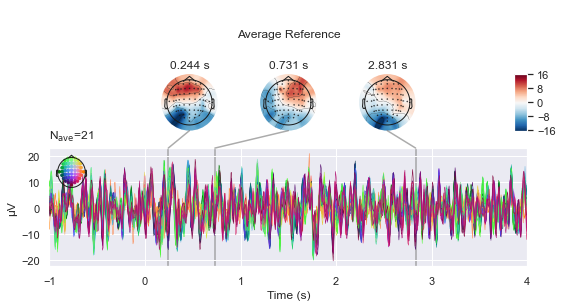

In [23]:
evoked = epochs['imagine/feet'].average()
evoked.plot_joint(title='Average Reference', show=False)
plt.show()

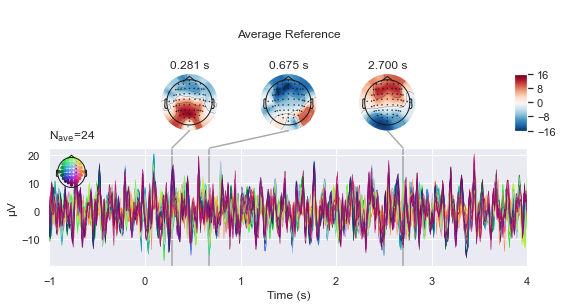

In [24]:
evoked = epochs['imagine/hands'].average()
evoked.plot_joint(title='Average Reference', show=False)
plt.show()

In [25]:
%matplotlib qt 
times = np.arange(-1, 4, 0.1)
fig, anim = evoked.animate_topomap(times=times, ch_type='eeg', frame_rate=2, time_unit='s', blit=False)

In [26]:
%matplotlib inline
sns.set(rc={'figure.figsize':(12,8)})

# Treatment pipeline
### [CSP, SPoC] @ [LinearDiscriminantAnalysis, LogisticRegression, RandomForestClassifier]

In [27]:
score_pipeline = -1
models_pipeline = None

Accuracy: 0.79 (+/- 0.10)


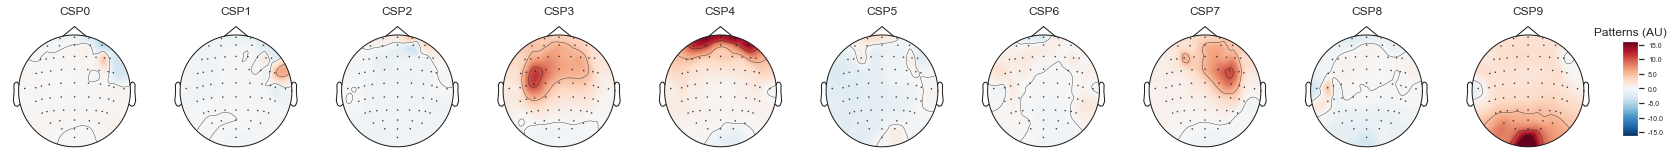

In [28]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
cv = ShuffleSplit(10, test_size=0.4, random_state=42)

# # Assemble a classifier 
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = make_pipeline(csp, lda)
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=-1)

# Printing the results
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
if scores.mean() > score_pipeline:
      score_pipeline = scores.mean()
      models_pipeline = clf

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)
csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
plt.show()

Accuracy: 0.79 (+/- 0.11)


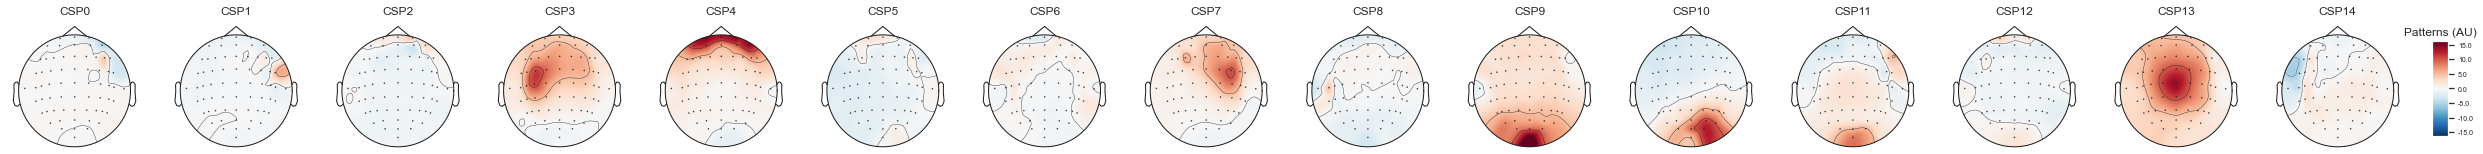

In [29]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
cv = ShuffleSplit(10, test_size=0.4, random_state=42)

# # Assemble a classifier
log_reg = LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto')
csp = CSP(n_components=15, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = make_pipeline(csp, log_reg)
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=-1)

# Printing the results
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
if scores.mean() > score_pipeline:
      score_pipeline = scores.mean()
      models_pipeline = clf

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)
csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
plt.show()

Accuracy: 0.84 (+/- 0.09)


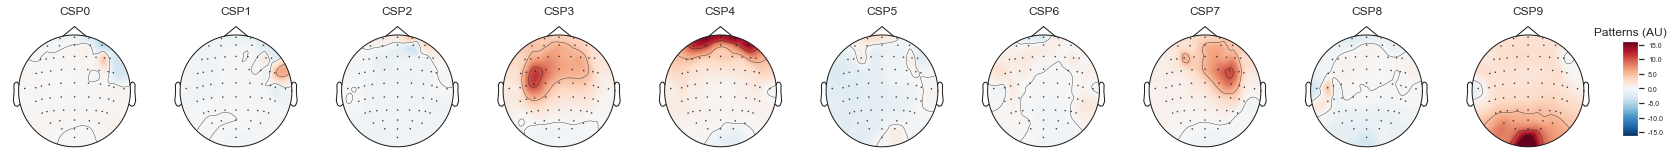

In [30]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
cv = ShuffleSplit(10, test_size=0.4, random_state=42)

# # Assemble a classifier
csp = CSP(n_components=10, reg=None, log=True, norm_trace=False)
rfc = RandomForestClassifier(n_estimators=150, random_state=42)

# Use scikit-learn Pipeline with cross_val_score function
clf = make_pipeline(csp, rfc)
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=-1)

# Printing the results
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
if scores.mean() > score_pipeline:
      score_pipeline = scores.mean()
      models_pipeline = clf

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)
csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
plt.show()

Accuracy: 0.69 (+/- 0.20)


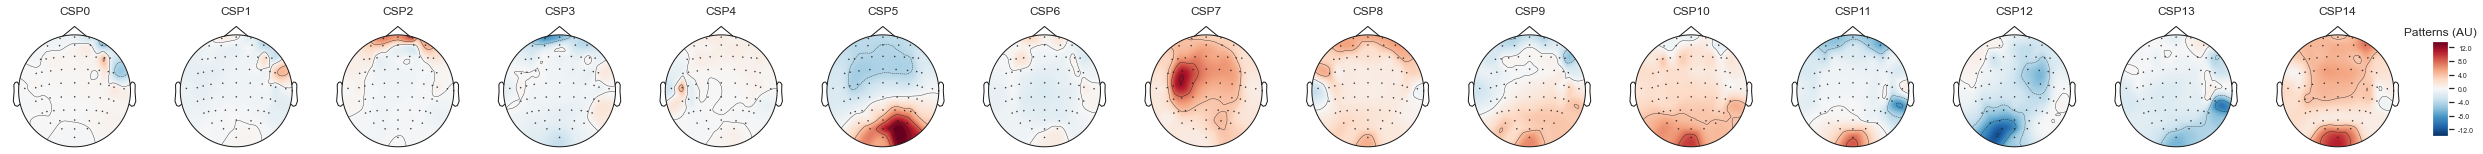

In [31]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
cv = ShuffleSplit(10, test_size=0.4, random_state=42)

# # Assemble a classifier
spoc = SPoC(n_components=15, log=True, reg='oas', rank='full')
log_reg = LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto')

# Use scikit-learn Pipeline with cross_val_score function
clf = make_pipeline(spoc, log_reg)
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=-1)

# Printing the results
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
if scores.mean() > score_pipeline:
      score_pipeline = scores.mean()
      models_pipeline = clf

# # plot SPoC patterns estimated on full data for visualization
spoc.fit_transform(epochs_data, labels)
spoc.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
plt.show()

Accuracy: 0.69 (+/- 0.22)


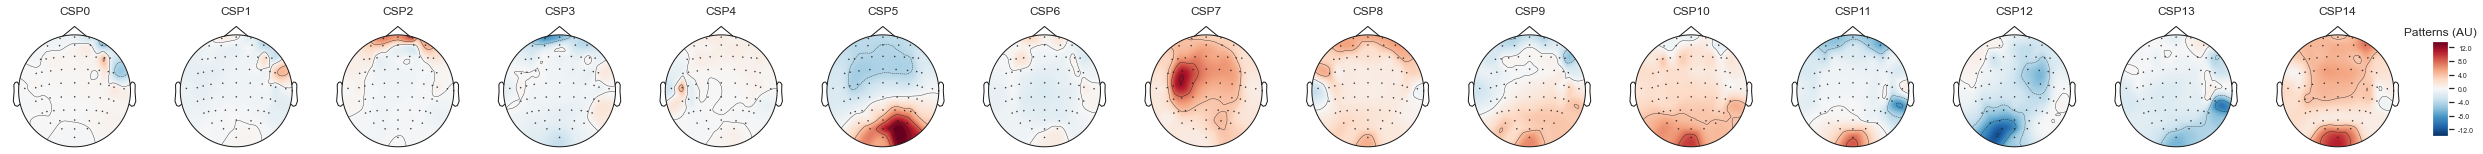

In [32]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
cv = ShuffleSplit(10, test_size=0.4, random_state=42)

# # Assemble a classifier
spoc = SPoC(n_components=15, log=True, reg='oas', rank='full')
lda = LinearDiscriminantAnalysis()

# Use scikit-learn Pipeline with cross_val_score function
clf = make_pipeline(spoc, lda)
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=-1)

# Printing the results
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
if scores.mean() > score_pipeline:
      score_pipeline = scores.mean()
      models_pipeline = clf

# # plot SPoC patterns estimated on full data for visualization
spoc.fit_transform(epochs_data, labels)
spoc.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
plt.show()

Accuracy: 0.73 (+/- 0.16)


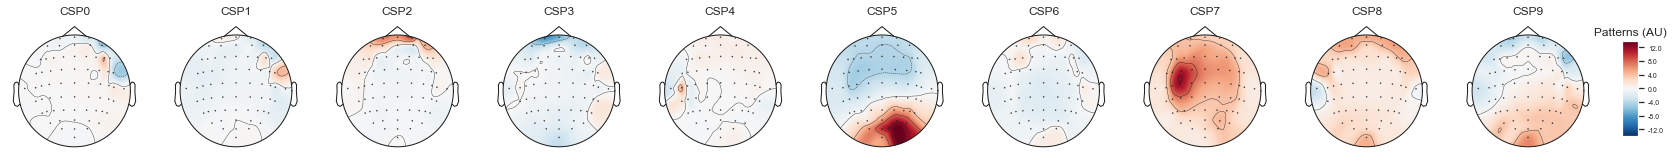

In [33]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
cv = ShuffleSplit(8, test_size=0.4, random_state=42)

# # Assemble a classifier
spoc = SPoC(n_components=10, log=True, reg='oas', rank='full')
rfc = RandomForestClassifier(n_estimators=150, random_state=42)

# Use scikit-learn Pipeline with cross_val_score function
clf = make_pipeline(spoc, rfc)
scores = cross_val_score(clf, epochs_data, labels, cv=cv, n_jobs=-1)

# Printing the results
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
if scores.mean() > score_pipeline:
      score_pipeline = scores.mean()
      models_pipeline = clf

# # plot SPoC patterns estimated on full data for visualization
spoc.fit_transform(epochs_data, labels)
spoc.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
plt.show()

# Best model

In [34]:
if models_pipeline is None:
    spoc = SPoC(n_components=10, log=True, reg='oas', rank='full')
    rfc = RandomForestClassifier(n_estimators=150, random_state=42)
    models_pipeline = make_pipeline(spoc, rfc)

In [35]:
score_pipeline

0.8444444444444444

In [36]:
models_pipeline

Pipeline(steps=[('csp',
                 CSP(component_order='mutual_info', cov_est='concat', cov_method_params=None,
  log=True, n_components=10, norm_trace=False, rank=None, reg=None,
  transform_into='average_power')),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=150, random_state=42))])

In [37]:
x_train, x_test, y_train, y_test = train_test_split(epochs_data, labels, test_size=0.4, random_state=92, shuffle=True)
clf.fit(x_train, y_train)

Pipeline(steps=[('spoc',
                 SPoC(cov_method_params=None, log=True, n_components=10, rank='full',
   reg='oas', transform_into='average_power')),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=150, random_state=42))])

In [38]:
clf.predict(x_test)

array([1, 0, 0, 3, 3, 2, 3, 0, 0, 1, 1, 2, 2, 2, 3, 3, 2, 2, 1, 0, 0, 0,
       3, 3, 1, 0, 1, 2, 0, 3, 1, 1, 2, 1, 1, 3])

In [39]:
clf.score(x_test, y_test)

0.8611111111111112

# Third Part

### Implement PCA

In [40]:
def my_PCA(X, n_comp = 2):
    X_cov_mat = np.cov(X)
    X_eig_val_cov, X_eig_vec_cov = np.linalg.eig(X_cov_mat)
    
    # Make a list of (eigenvalue, eigenvector) tuples
    X_eig_pairs = [(np.abs(X_eig_val_cov[i]), X_eig_vec_cov[:,i]) for i in range(len(X_eig_val_cov))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    X_eig_pairs.sort(key=lambda x: x[0], reverse=True)

    X_sum = 0.
    for i in X_eig_pairs:
        X_sum += i[0]
    print(X_sum)
    
    X_matrix_w = np.hstack((X_eig_pairs[0][1].reshape(2624,1), X_eig_pairs[1][1].reshape(2624,1)))
    for i in range(2, n_comp):
        X_matrix_w = np.hstack((X_matrix_w, X_eig_pairs[1][1].reshape(2624,1)))
    print('Matrix W:\n', X_matrix_w)
    
    X_transformed = X_matrix_w.T.dot(X)
    return X_transformed

In [42]:
data_3D = epochs.crop(tmin=0.25, tmax=.5).get_data()

list_of_lists = []
for i in range(len(data_3D)):
    one_list = []
    for j in range(len(data_3D[i])):
        one_list += list(data_3D[i][j])
    list_of_lists.append(np.array(one_list))
    
data_2D = np.array(list_of_lists)
print(data_2D.shape)

X = data_2D.T
print(X.shape)

(90, 2624)
(2624, 90)


In [43]:
X_transformed = my_PCA(X, 2)

1.8093967068148062e-06
Matrix W:
 [[-0.00992965+0.j -0.02282619+0.j]
 [-0.02234038+0.j -0.01552519+0.j]
 [-0.03098508+0.j -0.01385697+0.j]
 ...
 [ 0.00206378+0.j  0.00111711+0.j]
 [ 0.00793577+0.j  0.00418208+0.j]
 [ 0.01101369+0.j  0.01291366+0.j]]


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


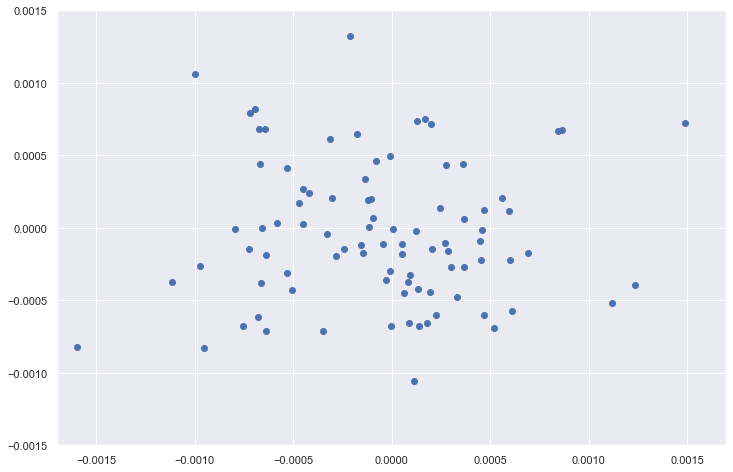

In [44]:
plt.scatter(X_transformed[0], X_transformed[1])
plt.xlim(-.0017, .0017)
plt.ylim(-.0015, .0015)
plt.show()

### Use sklearn_PCA

In [45]:
sklearn_pca = PCA(n_components=2)
sklearn_transf = sklearn_pca.fit_transform(X.T)
sklearn_transf.shape

(90, 2)

(-0.0015, 0.0015)

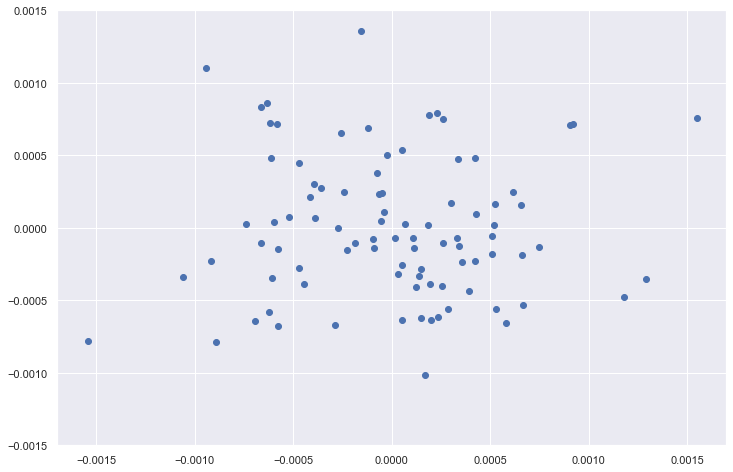

In [46]:
plt.scatter(sklearn_transf.T[0], sklearn_transf.T[1])
plt.xlim(-.0017, .0017)
plt.ylim(-.0015, .0015)